In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Load data

In [3]:
pd.set_option("display.max_columns", None)
data_dir = Path.cwd().parent / "data"

In [4]:
# 1. CRSP–Compustat
crsp_compustat = pd.read_csv(
    data_dir / "crsp_compustat_raw.csv",
    parse_dates=["datadate", "MthCalDt"],
)

# Handle data
crsp_compustat["YYYYMM"] = pd.to_datetime(
    crsp_compustat["YYYYMM"], format="%Y%m"
).dt.to_period("M")
crsp_compustat["cal_year"] = crsp_compustat["MthCalDt"].dt.year
crsp_compustat["PERMNO"] = crsp_compustat["PERMNO"].astype("Int64")

# Keep only data on CRSP
crsp_compustat = crsp_compustat[crsp_compustat["PERMNO"].notna()]

# Keep only one entry per fiscal year, keeping the latest one
crsp_compustat = crsp_compustat.sort_values(
    ["PERMNO", "fyear", "datadate"]
).drop_duplicates(subset=["PERMNO", "fyear"], keep="last")

In [5]:
# 2. CRSP
crsp = pd.read_csv(
    data_dir / "crsp_raw.csv",
    parse_dates=["date"],
)

# Handle data
crsp["cal_year"] = crsp["date"].dt.year
crsp["PERMNO"] = crsp["PERMNO"].astype("Int64")
crsp["RET"] = pd.to_numeric(crsp["RET"], errors="coerce")

# Sort for all downstream rolling ops
crsp = crsp.sort_values(["PERMNO", "date"])


def geo_mean_return(x: pd.Series):
    # Drop NaNs, require at least one obs
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    return (1.0 + x).prod() ** (1.0 / len(x)) - 1.0


annual_ret = (
    crsp.groupby(["PERMNO", "cal_year"])
    .agg(
        ret_arith=("RET", "mean"),
        ret_geo=("RET", geo_mean_return),
        n_months=("RET", "count"),  # useful sanity check
        SHRCD=("SHRCD", "first"),
        EXCHCD=("EXCHCD", "first"),
    )
    .reset_index()
)


def add_36m_vol(group: pd.DataFrame) -> pd.DataFrame:
    # Sort, put date as index
    g = group.sort_values("date").set_index("date")

    # Enforce a regular monthly index (month-end). Missing months become NaN rows.
    g = g.asfreq("ME")

    # Rolling over the last 36 monthly observations (36 calendar months)
    g["vol_36m"] = g["RET"].rolling(window=36, min_periods=12).std()

    return g.reset_index()


crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)
crsp_with_vol["cal_year"] = crsp_with_vol["date"].dt.year

# Pick the last month in each calendar year for each PERMNO
year_end_rows = (
    crsp_with_vol.sort_values(["PERMNO", "date"])
    .groupby(["PERMNO", "cal_year"])
    .tail(1)  # last monthly obs in that year
)

annual_vol = year_end_rows[["PERMNO", "cal_year", "vol_36m"]]

annual_crsp = annual_ret.merge(annual_vol, on=["PERMNO", "cal_year"], how="left")


C:\Users\chris\AppData\Local\Temp\ipykernel_52620\26881786.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)


In [6]:
# 3. Merge
df = crsp_compustat.merge(
    annual_crsp,
    on=["PERMNO", "cal_year"],
    how="left",
)

df = df.sort_values(["PERMNO", "MthCalDt"])

### Factors

In [7]:
# Here we might want to consider fallbacks if these are not available
df["book_equity"] = df["ceq"] + df["txdb"] - df["pstk"]
mask = df["book_equity"].isna()
df.loc[mask, "book_equity"] = (
    df.loc[mask, "at"] - df.loc[mask, "lt"] + df.loc[mask, "pstk"] - df.loc[mask, "seq"]
)
mask = df["book_equity"].isna()
df.loc[mask, "book_equity"] = df.loc[mask, "at"] - df.loc[mask, "lt"]

# Value factor
df["value"] = df["MthCap"] / df["book_equity"]

# Profitability factor
df["oiadp"] = df["oibdp"] - df["dp"]
df["profitability"] = df["oiadp"] / df["book_equity"]

# Investing
df["prev_at"] = df.groupby("PERMNO")["at"].shift(1)
df["investment"] = df["prev_at"] / df["at"]
df = (
    df.groupby("PERMNO", group_keys=False)
    .apply(lambda g: g.iloc[1:])
    .reset_index(drop=True)
)
# df = df[df["prev_at"].notna()].reset_index(drop=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_52620\1961662625.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[1:])


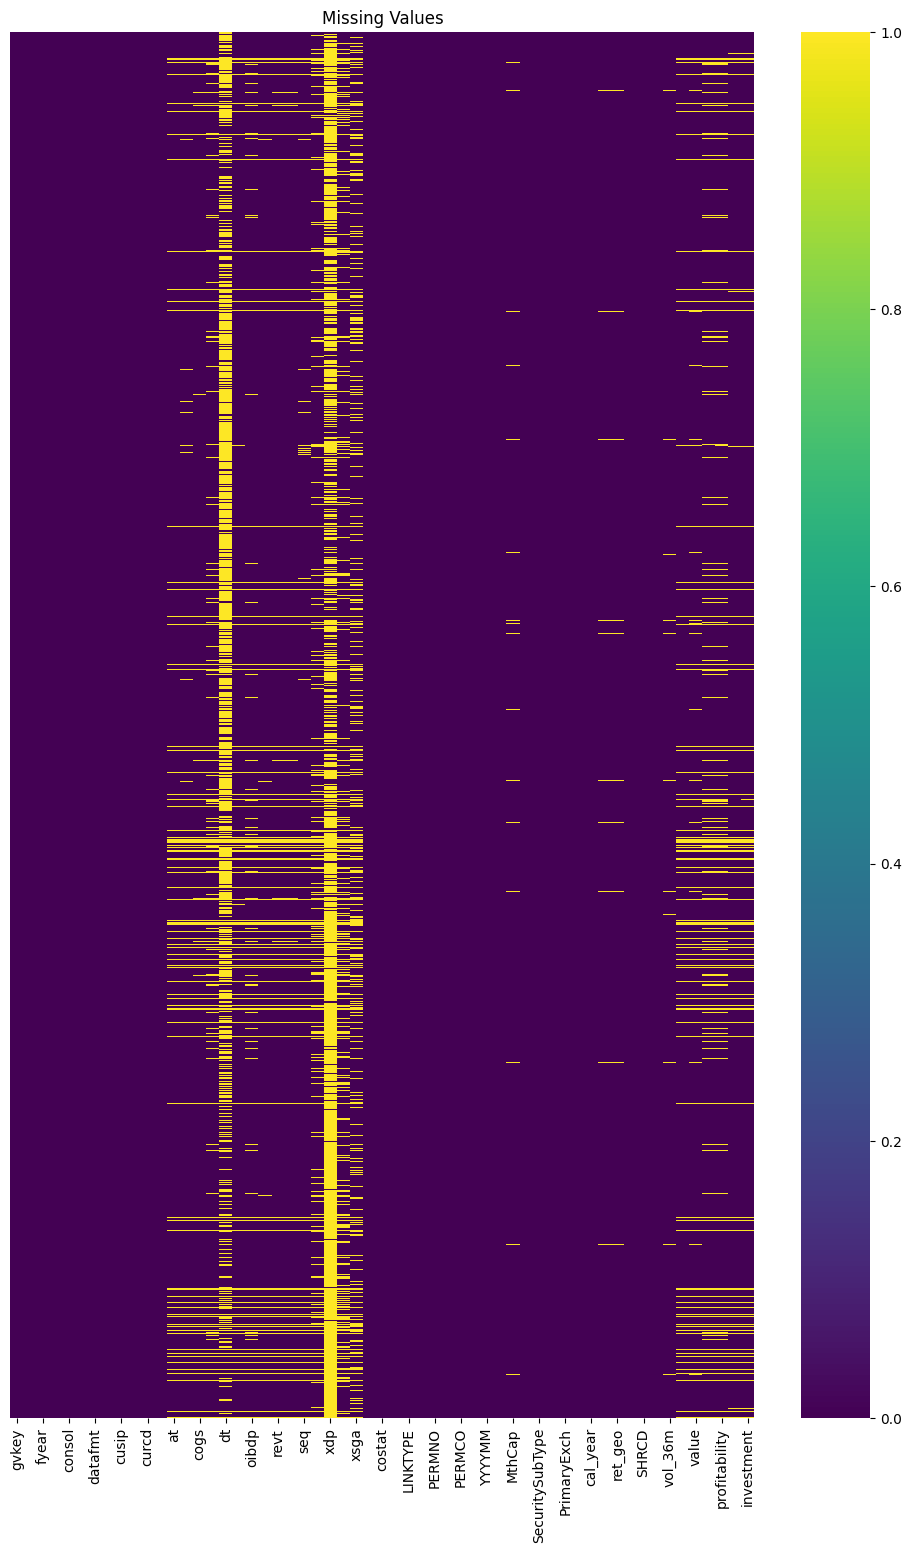

In [8]:
plt.figure(figsize=(12, 18))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

### Stock universe filtering

In [9]:
# Filters:
df = df[df["SHRCD"].isin([10, 11])]  # common stock only
df = df[df["EXCHCD"].isin([1, 2, 3])]  # NYSE/AMEX/NASDAQ
df = df[(df["SICCD"] < 6000) | (df["SICCD"] > 6799)]  # no finance/insurance/REIT

# Now use a heuristic for finding big companies to only include, used to avoid survivorship-bias
# Assume we can use the MthCap per company, and that the timings align for comparing market capitalization

# NYSE only firms
nyse = df[df["EXCHCD"] == 1]

# Compute NYSE median each year
size_breakpoints = (
    nyse.groupby(nyse["MthCalDt"].dt.year)["MthCap"].median().rename("NYSE_Median")
)

df = df.merge(size_breakpoints, left_on=df["MthCalDt"].dt.year, right_index=True)

# Assign BIG / SMALL
df["SIZE"] = np.where(df["MthCap"] >= df["NYSE_Median"], "BIG", "SMALL")

# The paper keeps ONLY big stocks
df_big = df[df["SIZE"] == "BIG"].copy()

In [10]:
# Define target columns
cols_to_keep = [
    # identifiers
    "PERMNO",
    "gvkey",
    "tic",
    "cusip",
    "conm",
    # "YYYYMM",
    "MthCalDt",
    "SHRCD",
    "EXCHCD",
    # market data
    "ShrOut",
    "MthCap",
    "ret_arith",
    "ret_geo",
    "n_months",
    "vol_36m",
    # core balance sheet variables
    "value",
    "investment",
    "prev_at",
    "book_equity",
    "at",
    "ceq",
    "seq",
    "pstk",
    "lt",
    # profitability
    "profitability",
    "oibdp",
    "oiadp",
    "revt",
    "sale",
    # expenses
    "cogs",
    "dp",
    "xint",
    "xsga",
    # tax
    "txdb",
    "dt",
    # industry
    "sic",
    "SICCD",
]

df_big = df_big[cols_to_keep].copy()

# Rename for clarity
df_big = df_big.rename(
    columns={
        "MthCap": "market_cap",
        "MthCalDt": "date",
        "ShrOut": "n_shares",
        "at": "total_assets",
        "ceq": "common_equity",
        "seq": "shareholders_equity",
        "pstk": "preferred_stock",
        "lt": "total_liabilities",
        "oibdp": "oper_income",
        "revt": "revenue",
        "sale": "sales",
        "cogs": "cogs_expense",
        "dp": "depr_amort",
        "xint": "interest_expense",
        "xsga": "sga_expense",
        "txdb": "tax_deferred",
        "dt": "total_taxes",
    }
)

df_big["date"] = df_big["date"].dt.to_period("Y")

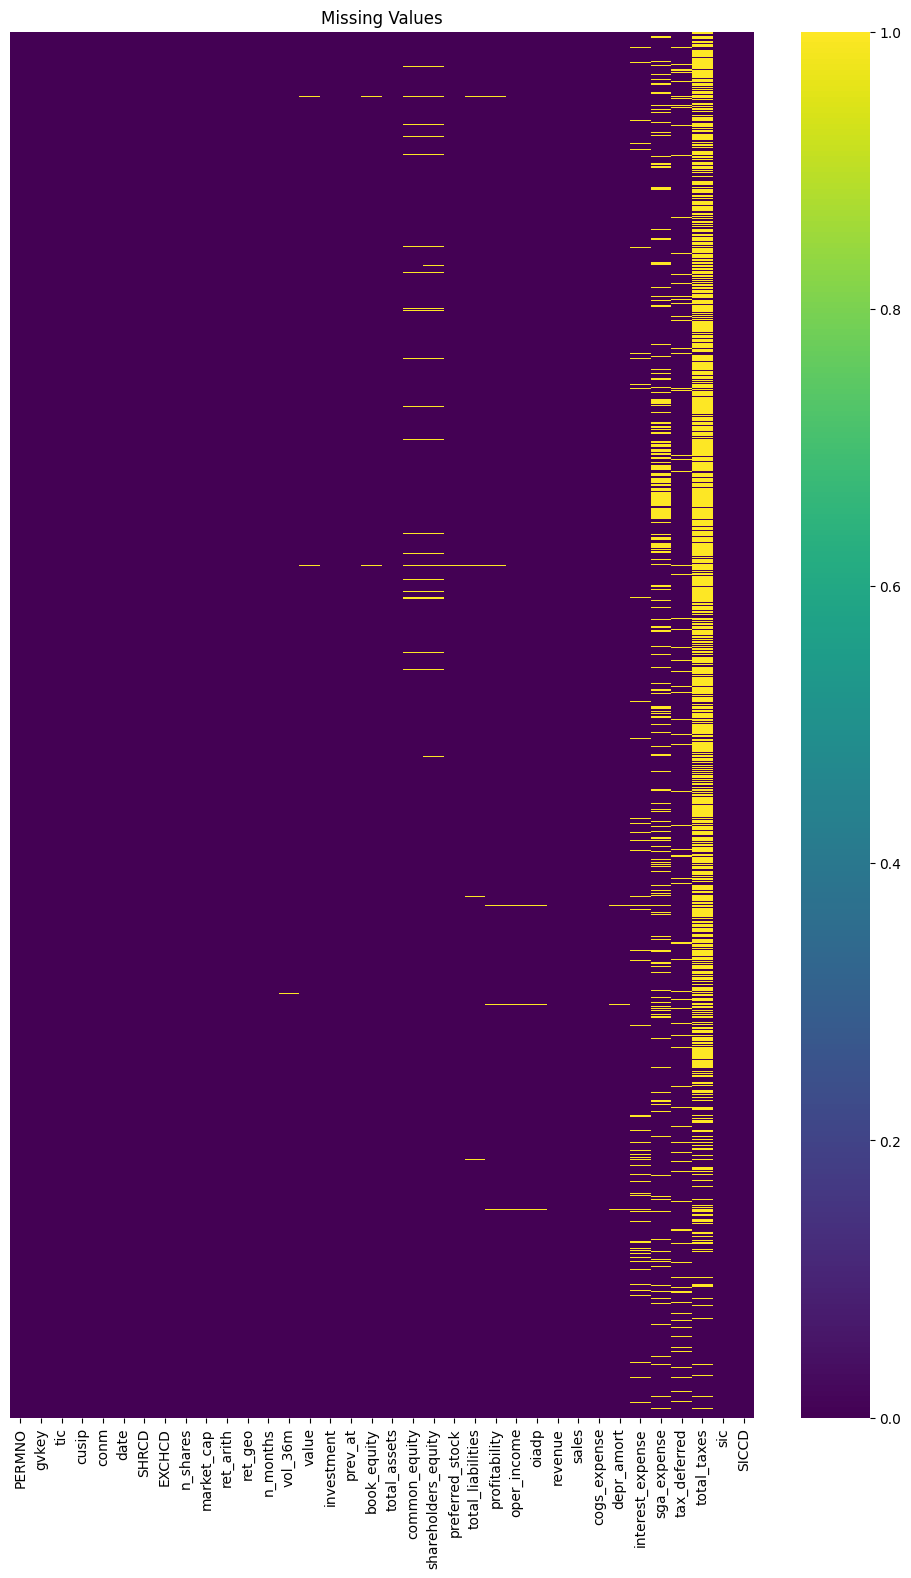

In [11]:
plt.figure(figsize=(12, 18))
sns.heatmap(df_big.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

In [12]:
df_big.to_csv(data_dir / "data_clean.csv", index=False)

In [31]:
final_cols = [
    "PERMNO",
    "date",
    "tic",
    "conm",
    # "cusip",
    "market_cap",
    "n_shares",
    "n_months",
    # "ret_arith",
    "ret_geo",
    "vol_36m",
    "value",
    "profitability",
    "investment",
]

df_factors = df_big[final_cols].copy()

In [32]:
df_factors["has_nan"] = df_factors.isnull().any(axis=1)

factors_summary = (
    df_factors.groupby("date")
    .agg(
        n_companies=("PERMNO", "nunique"),
        n_with_nan=("has_nan", "sum"),
    )
    .reset_index()
)

factors_summary.to_csv(data_dir / "factors_summary_by_year.csv", index=False)

In [33]:
# Remove companies that have any NaN values across their company-years before saving
df_factors = df_factors.drop(columns=["has_nan"])
companies_with_any_nan = df_factors.loc[
    df_factors.isnull().any(axis=1), "PERMNO"
].unique()

print(f"{len(companies_with_any_nan)} companies with nan")

# Remove those companies entirely (all their rows)
df_factors = df_factors[~df_factors["PERMNO"].isin(companies_with_any_nan)].reset_index(
    drop=True
)

88 companies with nan


In [34]:
df_factors.to_csv(data_dir / "factors.csv", index=False)